## Demonstration of how `sfrmaker` handles streambed elevations

In [1]:
import sys
import glob
import os
sys.path.append('..')
sys.path += glob.glob('/Users/aleaf/Documents/GitHub/*')
import numpy as np
import pandas as pd
import flopy
fm = flopy.modflow
from sfrmaker import lines, StructuredGrid
from sfrmaker.utils import assign_layers


flopy is installed in /Users/aleaf/Documents/GitHub/flopy/flopy


### Run the first part of the Tyler Forks example problem to get an `sfrdata` instance

In [2]:

# NHDPlus input files (see the input requirements in the SFRmaker readme file
# (Note that multiple datasets can be supplied as lists
# when the SFR area covers multiple drainage basins)
data_dir = '../data/badriver'
pfvaa_files = ['{}/PlusFlowlineVAA.dbf'.format(data_dir)]
plusflow_files = ['{}/PlusFlow.dbf'.format(data_dir)]
elevslope_files = ['{}/elevslope.dbf'.format(data_dir)]
flowlines = ['{}/NHDFlowlines.shp'.format(data_dir)]

# DEM for sampling streambed top elevations
dem = '{}/dem_26715.tif'.format(data_dir)

# output folder
outdir = 'temp/'
if not os.path.isdir(outdir):
    os.mkdir(outdir)

# make an instance of the sfrmaker.lines class from NHDPlus data
# use a shapefile of the model grid to filter what is read in
# (only flowlines within the bounding box of the grid)
lns = lines.from_NHDPlus_v2(NHDFlowlines=flowlines,
                            PlusFlowlineVAA=pfvaa_files,
                            PlusFlow=plusflow_files,
                            elevslope=elevslope_files,
                            filter='{}/grid.shp'.format(data_dir))

# make a flopy.utils.reference.SpatialReference instance
# that represents the model grid
m = fm.Modflow.load('tf.nam', model_ws='{}/tylerforks'.format(data_dir))

sr = flopy.utils.SpatialReference(delr=m.dis.delr.array,  # cell spacing along a row
                                  delc=m.dis.delc.array,  # cell spacing along a column
                                  lenuni=1,  # model units of feet
                                  xll=682688, yll=5139052,  # lower left corner of model grid
                                  rotation=0,  # grid is unrotated
                                  proj4_str='+init=epsg:26715'  # projected coordinate system of model (UTM NAD27 zone 15 North)
                                  )
m.sr = sr

# make a sfrmaker.StructuredGrid instance from the SpatialReference
# active_area is a polygon that specifies the area where SFR reaches will be populated
grd = StructuredGrid.from_sr(sr,
                             active_area='{}/active_area.shp'.format(data_dir)
                             )

# from the lines and StructuredGrid instances, make a sfrmaker.sfrdata instance
# (lines are intersected with the model grid and converted to reaches, etc.)
sfr = lns.to_sfr(grd, model=m)


loading NHDPlus v2 hydrography data...

reading ../data/badriver/NHDFlowlines.shp...
filtering on bounding box -90.6248357553437, 46.37887269899105, -90.46288279328367, 46.45901586231695...
--> building dataframe... (may take a while for large shapefiles)

reading ../data/badriver/PlusFlowlineVAA.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading ../data/badriver/PlusFlow.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading ../data/badriver/elevslope.dbf...
--> building dataframe... (may take a while for large shapefiles)

load finished in 0.12s

Getting routing information from NHDPlus Plusflow table...
finished in 0.04s


reading ../data/badriver/active_area.shp...
--> building dataframe... (may take a while for large shapefiles)
setting isfr values...
Intersecting 1 features...
1
finished in 0.59s

Creating sfr dataset...
Model grid information
structured grid
nnodes: 17,760
nlay: 1
nrow: 111
ncol: 160
model length units: 

### Sample elevations from the DEM
* the **buffers** method draws a buffer around each LineString representing a reach (default=100m), and then gets the minimum DEM elevation within that buffer, using the **`rasterstats`** package
* alternatively, the **`cell polygons`** method would do the same thing using the model cell polygons instead to represent the reaches
* get results with and without smoothing. 

#### pseudo code for the smoothing algoritm:  


```
Starting at the outlets to the stream network, list the reaches at each level (reaches that route to an outlet, reaches that route to reaches that route to an outlet, etc...)
For each level:
    For each stream reach within the level:
        Get the elevations of all upstream reaches (that route to that reach)
            Set the elevation as the minimum of the elevation sampled at the current reach and the elevations sampled at all upstream reaches.
```
        

In [3]:
raw_sampled_elevs = sfr.sample_reach_elevations(dem, method='buffers', smooth=False)
smooth_sampled_elevs = sfr.sample_reach_elevations(dem, method='buffers', smooth=True)

running rasterstats.zonal_stats on buffered LineStrings...
finished in 1.87s

running rasterstats.zonal_stats on buffered LineStrings...
finished in 1.83s


Smoothing elevations...
finished in 0.09s


### Make comparison plots of the elevations in each segment
* model_top: elevations sampled from the DEM at the cell centers
* nhdplus_elevations: reach elevations linearly interpolated from original COMID end elevations in NHDPlus
* raw_sampled_elevs: minimum DEM elevations within each buffered LineString
* smooth_sampled_elevs: minimum DEM elevations within each buffered LineString with smoothing applied

#### Note:
One of the segments has NHDPlus elevations that are much higher than the model top or DEM. This is due to the segment originating outside of the model domain, which means the COMID start elevation from NHDPlus is invalid.

In [8]:
dfs = []
segments = sfr.reach_data.groupby('iseg')
for iseg, srd in segments:
    df = srd.copy()
    df['dist'] = srd.rchlen.cumsum()
    df['nhdplus_elevation'] = df.strtop
    dfs.append(df[['i', 'j', 'rno', 'iseg', 'ireach', 'dist', 'nhdplus_elevation']])
df = pd.concat(dfs)
df['model_top'] = sfr.model.dis.top.array[df.i, df.j]
df['raw_sampled_elevs'] = [raw_sampled_elevs[rno]
                              for rno in df['rno'].values]
df['smooth_sampled_elevs'] = [smooth_sampled_elevs[rno]
                              for rno in df['rno'].values]
df['smooth_sampled_elevs'] /= .3048 # convert from meters to feet
df['raw_sampled_elevs'] /= .3048

/Users/aleaf/anaconda3/envs/gis/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=45.13792037963867, right=45.13792037963867
  ax.set_xlim(left, right)


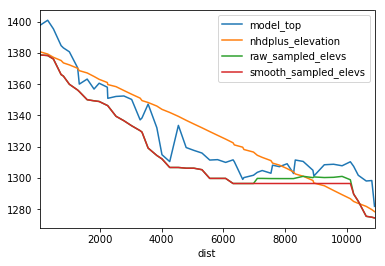

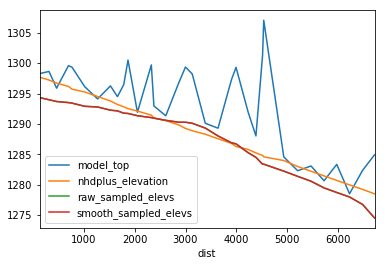

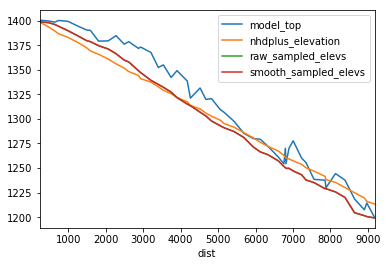

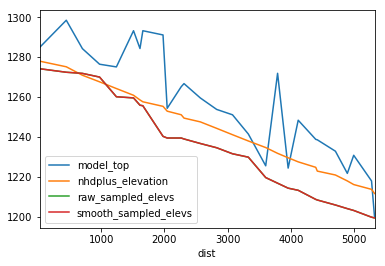

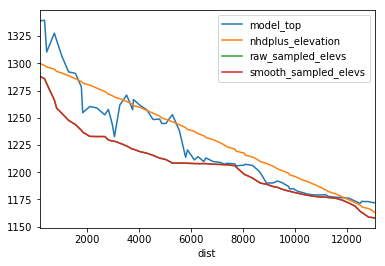

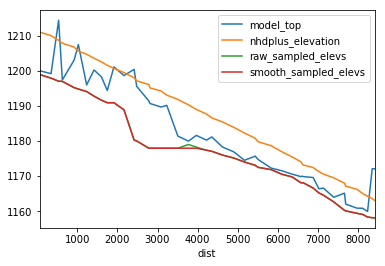

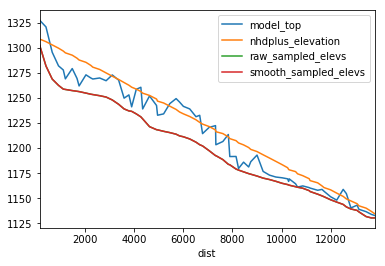

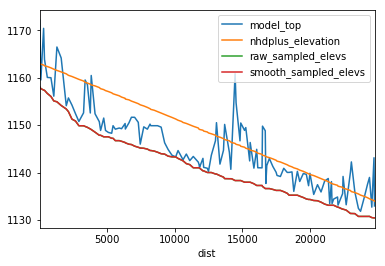

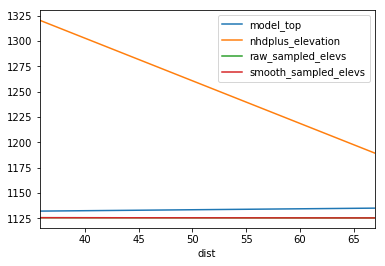

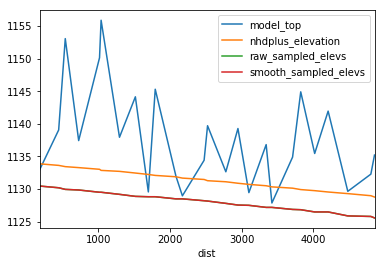

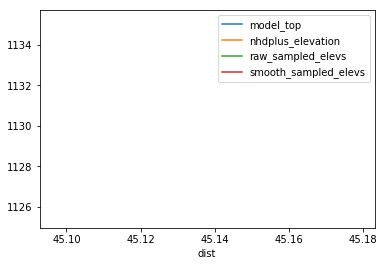

In [9]:
segments = df.groupby('iseg')
for iseg, srd in segments:
    srd = srd.copy()
    srd.index = srd.dist
    srd[['model_top', 'nhdplus_elevation', 'raw_sampled_elevs', 'smooth_sampled_elevs']].plot()